<a href="https://colab.research.google.com/github/Nam-SW/drawing_game/blob/master/AI_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 다운로드 및 전처리

코랩은 클라우드 시스템이므로, 로컬에 저장된 파일을 접속할수 없음. 따라서 파일을 로컬이 아닌 클라우드에 올림.
데이터셋을 저장할 디렉토리 생성. 

얘는 이 ipynb 파일에서만 사용.

In [0]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'
!mkdir dataset

--2019-09-23 11:50:45--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2019-09-23 11:50:50 (175 MB/s) - ‘mini_classes.txt’ saved [760/760]



클래스 형식으로 구현

In [0]:
import os
import glob
import numpy as np
from urllib.request import urlretrieve # 웹에서 데이터를 다운로드하는 함수
from pprint import pprint
import keras
from keras import backend as K
from tqdm import tqdm_notebook # 진행바


class Data:
    def __init__(self, root='dataset'):
        self.download_data()
        self.load_data(root)
        self.add_channels()
        self.preprocess()

        
    def download_data(self):
        with open('mini_classes.txt', 'r') as f:
            classes = f.readlines() # 데이터는 object\n ... 으로 구성됨. 
            classes = [c.replace('\n','').replace(' ','_') for c in classes] # 줄바꿈 포맷팅 문자 제거, 공백문자 처리

        # pprint(classes) # 기분좋게 잘 구분됐는지 확인
        # print(len(classes))

        base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' # 데이터셋을 다운하는 페이지. 이 url에 클래스명.npy를 붙이면 넘파이 파일로 다운 가능
        for c, _ in zip(classes, tqdm_notebook(range(1, 101))):
            path = base + c.replace('_', '%20') + '.npy' # 경로설정
            # print(path) # 경로 확인!
            urlretrieve(path, 'dataset/'+c+'.npy') # dataset 디렉토리에 클래스명.npy 형식으로 저장

    
    def load_data(self, root='dataset', vfold_ratio=0.2, max_items_per_class=4000):
        # dataset 디렉토리 안의 확장자가 npy인 파일의 이름들을 리스트로 반환
        all_files = glob.glob(os.path.join(root, '*.npy')) 

        # 변수 초기화
        x = np.empty([0, 784])
        y = np.empty([0])
        class_names = []

        # 데이터 불러오기
        for idx, file in enumerate(all_files):
            data = np.load(file)
            data = data[0: max_items_per_class, :]
            labels = np.full(data.shape[0], idx)

            x = np.concatenate((x, data), axis=0)
            y = np.append(y, labels)

            class_name, ext = os.path.splitext(os.path.basename(file))
            class_names.append(class_name)
        
        data = None
        labels = None
    
        # 데이터셋을 랜덤으로 지정함
        permutation = np.random.permutation(y.shape[0])
        x = x[permutation, :]
        y = y[permutation]

        # 학습셋과 평가셋으로 분리
        vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

        x_test = x[0:vfold_size, :]
        y_test = y[0:vfold_size]

        x_train = x[vfold_size:x.shape[0], :]
        y_train = y[vfold_size:y.shape[0]]
        
        self.class_name = class_name
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.raw_y_train = y_train # 테스트셋 시각화를 위한 데이터
        self.raw_y_test = y_test
        self.class_names = class_names
        self.num_of_classes = len(class_names)
        
    def add_channels(self):
        x_train, x_test = self.x_train, self.x_test

        # 흑백 이미지의 경우 채널 정보가 없으므로 이를 추가한다. 컬러사진의 경우 그딴거 필요없음
        if K.image_data_format == 'channels_first': # 시애노 방식, 채널 정보가 앞에 있는경우
            x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
            x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
        else: # 텐서플로 방식, 채널 정보가 뒤에 있는 경우
            x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
            x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

        self.x_train = x_train
        self.x_test = x_test
        
    def preprocess(self):
        print(type(self.x_train[0]))
        x_train, y_train, x_test, y_test = self.x_train, self.y_train, self.x_test, self.y_test # 지역변수화
        
        x_train = x_train.astype('float32') # 케라스에서 처리하기 쉽도록 0~1사이의 실수로 정규화
        x_test = x_test.astype('float32')
        x_train /= 255.0
        x_test /= 255.0
        
        y_train = keras.utils.to_categorical(y_train, self.num_of_classes) # 원핫인코딩
        y_test = keras.utils.to_categorical(y_test, self.num_of_classes)
        
        print(type(self.x_train[0]))
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.input_shape = x_train.shape[1:] # 0번 인덱스는 데이터의 개수를 나타냄.


Using TensorFlow backend.


# 모델 구성

모델 역시 클래스로 작성. 기본적으로 컨볼루션 레이어를 사용하며, 연쇄 방식으로 구현함.

In [0]:
from keras import layers
from keras.models import Sequential


# class model(Sequential):
#     # def __init__(self, input_shape, num_of_classes, **kwargs):
#     #     self.data_shape = input_shape
#     #     self.num_of_classes = num_of_classes
#     def __init__(self, **kwargs):
#         self.data_shape = (28, 28, 1)
#         self.num_of_classes = 100
#         self.build_model()
#         self.model_compile()
#         print(self.summary())
        
#     def build_model(self):
#         input_shape = self.data_shape   
#         num_of_classes = self.num_of_classes
#         super().__init__()
        
#         self.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='c1'))
#         self.add(layers.MaxPooling2D(pool_size=(2, 2), name='m1'))
#         self.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu', name='c2'))
#         self.add(layers.MaxPooling2D(pool_size=(2, 2), name='m2'))
#         self.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu', name='c3'))
#         self.add(layers.MaxPooling2D(pool_size =(2,2), name='m3'))
#         self.add(layers.Flatten(name='f'))
#         self.add(layers.Dropout(0.2, name='drop'))
#         self.add(layers.Dense(128, activation='relu', name='den'))
#         self.add(layers.Dense(num_of_classes , activation='softmax', name='output'))
        
#     def model_compile(self):
#         self.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
        

def model(input_shape, num_of_classes):
    m = Sequential()
    m.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='c1'))
    m.add(layers.MaxPooling2D(pool_size=(2, 2), name='m1'))
    m.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu', name='c2'))
    m.add(layers.MaxPooling2D(pool_size=(2, 2), name='m2'))
    m.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu', name='c3'))
    m.add(layers.MaxPooling2D(pool_size =(2,2), name='m3'))
    m.add(layers.Flatten(name='f'))
    m.add(layers.Dropout(0.2, name='drop'))
    m.add(layers.Dense(128, activation='relu', name='den'))
    m.add(layers.Dense(num_of_classes , activation='softmax', name='output'))

    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return m

# 그래프 함수 정의

학습과정의 정확도, 손실률을 그려주는 함수 정의

In [0]:
import matplotlib.pyplot as plt

def plot_graph(history, yname, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    if yname == 'acc':
        plt.plot(history['acc']) # 선 그리기
        plt.plot(history['val_acc'])
        plt.ylabel('Accuracy') # y축 이름 표시
    else:
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.ylabel('Loss') # y축 이름 표시
        
    if title is not None:
        plt.title(title) # 그래프 제목 표시
    
    plt.xlabel('Epoch') # x축 이름 표시
    plt.legend(['Training', 'Verification'], loc=0) # 각 라인의 표식 표시
    plt.show()

# 실행 부분
개별 실행

In [0]:
dataset = Data() # 데이터셋 불러오기

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


table
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
100


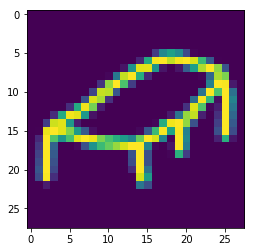

In [0]:
# 랜덤한 데이터값을 출력해줌
from random import randint
%matplotlib inline  
idx = randint(0, len(dataset.x_train))
plt.imshow(dataset.x_train[idx].reshape(28,28)) 
print(dataset.class_names[int(dataset.raw_y_train[idx].item())])
print(dataset.y_train[0])
print(len(dataset.y_train[0]))

# 데이터셋 확인
# for i in range(28):
#     for j in range(28):
#         print(dataset.x_train[idx][i][j], end='')
#     print('')

In [0]:
print(type(dataset.x_train[0]))
print(type(dataset.y_train[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
Model = model(dataset.input_shape, dataset.num_of_classes) # 모델 정의
# Model = model() # 모델 정의
Model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c1 (Conv2D)                  (None, 28, 28, 16)        160       
_________________________________________________________________
m1 (MaxPooling2D)            (None, 14, 14, 16)        0         
_________________________________________________________________
c2 (Conv2D)                  (None, 14, 14, 32)        4640      
_________________________________________________________________
m2 (MaxPooling2D)            (None, 7, 7, 32)          0         
_________________________________________________________________
c3 (Conv2D)                  (None, 7, 7, 64)          18496     
_________________________________________________________________
m3 (MaxPooling2D)            (None, 3, 3, 64)          0        

In [0]:
# 모델 학습 및 평가
history = Model.fit(dataset.x_train, dataset.y_train, epochs=20, batch_size=256, validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 288000 samples, validate on 32000 samples
Epoch 1/20
288000/288000 [==============================] - 33s 114us/step - loss: 1.9901 - acc: 0.5087 - val_loss: 1.3140 - val_acc: 0.6704
Epoch 2/20
288000/288000 [==============================] - 25s 88us/step - loss: 1.2879 - acc: 0.6729 - val_loss: 1.1165 - val_acc: 0.7217
Epoch 3/20
288000/288000 [==============================] - 25s 88us/step - loss: 1.1385 - acc: 0.7078 - val_loss: 1.0173 - val_acc: 0.7420
Epoch 4/20
288000/288000 [==============================] - 23s 79us/step - loss: 1.0546 - acc: 0.7283 - val_loss: 0.9670 - val_acc: 0.7542
Epoch 5/20
288000/288000 [==============================] - 23s 81us/step - loss: 1.0009 - acc: 0.7424 - val_loss: 0.9305 - val_acc: 0.7635
Epoch 6/20
288000/288000 [==============================] - 21s 74us/step - loss: 0.9601 - acc: 0.7515 - val_loss: 0.9073 - val_acc: 0.7698
Epoch 7/20
288

# 학습 성능 평가

모델 성능 평가 및 정확도 출력

In [0]:
score = Model.evaluate(dataset.x_test, dataset.y_test, verbose=1)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

80000/80000 [==============================] - 5s 65us/step
Test accuarcy: 79.61%


학습 과정 그래프 그리기

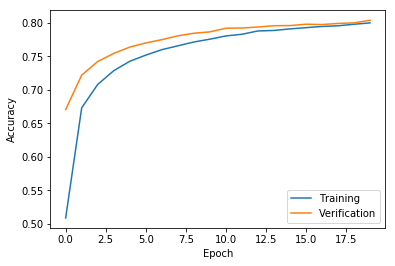

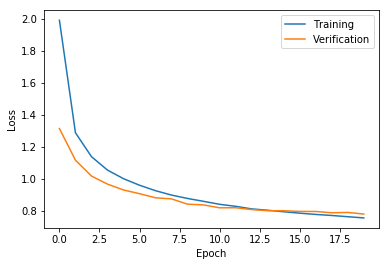

In [0]:
plot_graph(history, 'acc')
plot_graph(history, 'loss')

임의의 값을 입력해 모델의 예상값과 실제 정답 출력

In [0]:
print(dataset.class_names)

['tent', 'syringe', 'camera', 'light_bulb', 'microphone', 'baseball_bat', 'star', 'spider', 'pants', 'car', 'stop_sign', 'bench', 'face', 'circle', 'cup', 'clock', 'cloud', 'knife', 'sock', 'moustache', 'ceiling_fan', 'suitcase', 'candle', 'bread', 'cat', 'saw', 'grapes', 'sword', 'scissors', 'sun', 'flower', 'bird', 'lollipop', 'snake', 'drums', 'hot_dog', 'chair', 'apple', 'headphones', 'anvil', 'bridge', 'pizza', 'eye', 'eyeglasses', 'cookie', 'envelope', 'bicycle', 'tennis_racquet', 'spoon', 'butterfly', 'airplane', 't-shirt', 'pillow', 'umbrella', 'tooth', 'book', 'ice_cream', 'basketball', 'coffee_cup', 'fan', 'shovel', 'lightning', 'triangle', 'dumbbell', 'frying_pan', 'wristwatch', 'broom', 'diving_board', 'door', 'alarm_clock', 'hat', 'ladder', 'line', 'table', 'rainbow', 'key', 'laptop', 'helmet', 'beard', 'rifle', 'axe', 'power_outlet', 'mushroom', 'radio', 'paper_clip', 'cell_phone', 'wheel', 'hammer', 'traffic_light', 'pencil', 'screwdriver', 'shorts', 'tree', 'baseball', 

[1.65534008e-03 2.52318930e-08 2.90043198e-11 4.51767028e-06
 2.44948581e-07 2.28293700e-07 4.89027570e-06 3.28058718e-08
 3.34237811e-05 2.30141906e-09 3.57555408e-08 5.16494140e-07
 7.10752715e-07 6.81432937e-07 1.06012576e-08 1.49735854e-06
 5.30965565e-08 1.36985625e-06 8.49294892e-08 1.14842733e-04
 3.28017113e-10 6.09676192e-07 1.85833020e-08 2.89497677e-07
 1.66335349e-06 6.39971233e-07 3.67291371e-08 2.11121119e-06
 5.56364057e-07 5.86982516e-08 5.01398789e-09 5.33084517e-07
 5.45803118e-08 1.24655823e-08 4.93987251e-08 1.32186997e-07
 1.14957821e-07 6.66721567e-10 3.19507194e-06 1.09612643e-06
 1.40253997e-05 4.38530590e-09 2.14653670e-10 5.08754397e-07
 4.37375336e-09 1.66736746e-11 2.48149161e-14 1.64814651e-07
 3.34699052e-07 1.77658919e-08 1.18687212e-05 2.38257098e-06
 3.98100201e-06 3.52432778e-07 6.13292605e-06 6.20552692e-06
 6.53955112e-08 1.84061122e-08 1.62752176e-08 3.16775974e-08
 8.28650002e-08 4.51092177e-07 4.04285856e-05 4.79303537e-07
 4.83886886e-08 2.017290

FileNotFoundError: ignored

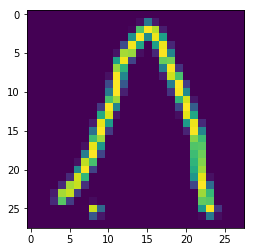

In [0]:
%matplotlib inline  
idx = 0 #randint(0, len(dataset.x_test))
img = dataset.x_test[idx]
plt.imshow(img.squeeze()) 
pred = Model.predict(np.expand_dims(img, axis=0))[0]
print(pred)
ind = (-pred).argsort()[:5]
print(ind)
latex = [dataset.class_names[x] for x in ind]

np.save('/content/gdrive/My Drive/image', img)

print('Estimate:  ', latex)
print('right Answer: ' + dataset.class_names[int(dataset.raw_y_test[idx].item())])

# 모델 저장 및 불러오기

모델 저장

In [0]:
from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/gdrive') # 구글 드라이브랑 마운트. 아래 뜨는 링크에 접속해서 코드를 복사해 붙여넣기한다.
Model.save('/content/gdrive/My Drive/Colab Notebooks/quick_draw.h5') # 저장

저장한 모델을 불러와 사용하기

In [0]:
# loaded_model = load_model('/content/gdrive/My Drive/Colab Notebooks/quick_draw.h5', custom_objects={'model':model, 'input_shape':dataset.input_shape, 'num_of_classes':dataset.num_of_classes})
# loaded_model = load_model('/content/gdrive/My Drive/Colab Notebooks/quick_draw.h5', custom_objects={'model':model})
loaded_model = load_model('/content/gdrive/My Drive/Colab Notebooks/quick_draw.h5')

In [0]:
%matplotlib inline  
idx = 100 #randint(0, len(dataset.x_test))
img = dataset.x_test[idx]
plt.imshow(img.squeeze()) 
pred = Model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [dataset.class_names[x] for x in ind]

print('Estimate:  ', latex)
print('right Answer: ' + dataset.class_names[int(dataset.raw_y_test[idx].item())])

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('/content/gdrive/My Drive/test2.png')
plt.imshow(image)
plt.show()
image = image.convert('1')
test = np.array(image.getdata()).reshape(560, 560, 1)

if [0] in test:
    print('a')

image.save('/content/gdrive/My Drive/test.png')